<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple Linear Regression with Sacramento Real Estate Data

_Authors: Matt Brems, Sam Stack_

---

In this lab you will hone your EDA skills and practice constructing simple linear regressions using a dataset on Sacramento real estate sales.  The dataset contains information on qualities of the property, location of the property, and time of sale.

### 1. Read in the Sacramento housing data set.

In [1]:
sac_csv = './sacramento_real_estate_transactions.csv'

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

%matplotlib inline

In [3]:
df = pd.read_csv(sac_csv)
df.head(1)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879


### 2. Conduct exploratory data analysis on this data set. 

**Report any notable findings here and any steps you take to clean/process data.**

> **Note:** These EDA checks should be done on every data set we give you. If you find yourself checking for, say, missing/corrupted data over and over, it might be to your long-term benefit to have a function that you can re-use every time you're given some new data.

In [4]:
# find the shape
df.shape

(985, 12)

In [5]:
# check the data types
df.dtypes

street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object

In [6]:
# descrive the features
df.describe(include='all')

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
count,985,985,985.000000,985,985.000000,985.000000,985.000000,985,985,985.000000,985.000000,985.000000
unique,981,39,NaN,2,NaN,NaN,NaN,4,5,NaN,NaN,NaN
top,4734 14TH AVE,SACRAMENTO,NaN,CA,NaN,NaN,NaN,Residential,Mon May 19 00:00:00 EDT 2008,NaN,NaN,NaN
freq,2,439,NaN,984,NaN,NaN,NaN,917,268,NaN,NaN,NaN
mean,NaN,NaN,95750.697462,NaN,2.911675,1.776650,1312.918782,NaN,NaN,233715.951269,38.445121,-121.193371
std,NaN,NaN,85.176072,NaN,1.307932,0.895371,856.123224,NaN,NaN,139088.818896,5.103637,5.100670
min,NaN,NaN,95603.000000,NaN,0.000000,0.000000,-984.000000,NaN,NaN,-210944.000000,-121.503471,-121.551704
25%,NaN,NaN,95660.000000,NaN,2.000000,1.000000,950.000000,NaN,NaN,145000.000000,38.482704,-121.446119
50%,NaN,NaN,95762.000000,NaN,3.000000,2.000000,1304.000000,NaN,NaN,213750.000000,38.625932,-121.375799
75%,NaN,NaN,95828.000000,NaN,4.000000,2.000000,1718.000000,NaN,NaN,300000.000000,38.695589,-121.294893


In [7]:
# Check for null values
df.isnull().sum()

street       0
city         0
zip          0
state        0
beds         0
baths        0
sq__ft       0
type         0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

In [8]:
# check value count for square feet
# 171 observations are recorded as 0 and can be treated as null
df.sq__ft.value_counts()

0       171
1120      8
795       6
1410      5
1039      5
       ... 
1656      1
876       1
1659      1
2687      1
1235      1
Name: sq__ft, Length: 604, dtype: int64

In [9]:
# check value count for bedrooms 
# to see if bedrooms + bath = total room count could operate as a default for square foot.
# There are 108 recorded as having zero bedrooms 
df.beds.value_counts()

3    413
4    258
2    133
0    108
5     59
1     10
6      3
8      1
Name: beds, dtype: int64

In [10]:
# Create a new column indicating rap or not rap
def sq_ft_0 (i):
    if i == 0:
        return '0_sq_ft'
    else:
        return '>0_sq_ft'
df['zero_sq__ft'] = df['sq__ft'].apply(sq_ft_0)

In [11]:
# Spot check if zero sq ft observations tend towards a specific type
# Answer: No
df.groupby('zero_sq__ft').type.value_counts()

zero_sq__ft  type        
0_sq_ft      Residential     158
             Condo            12
             Unkown            1
>0_sq_ft     Residential     759
             Condo            42
             Multi-Family     13
Name: type, dtype: int64

In [12]:
# Spot check if there are any records greater than 0 sq ft do not have any bedrooms 
# Answer: No
# If sq_ft is a main driver should exlude observations that have 0 sq foot.
df.groupby('zero_sq__ft').beds.value_counts()

zero_sq__ft  beds
0_sq_ft      0       108
             4        23
             3        21
             5        10
             2         8
             6         1
>0_sq_ft     3       392
             4       235
             2       125
             5        49
             1        10
             6         2
             8         1
Name: beds, dtype: int64

In [13]:
# check if price has reasonable values distribution
# The 4987 price looks unusually low and unusually common. Should screen these out. 
df.price.value_counts()

4897      49
220000    10
150000     9
250000     9
170000     9
          ..
212500     1
579093     1
300567     1
63000      1
512000     1
Name: price, Length: 605, dtype: int64

In [14]:
# spot check results where price == 4897
df[df.price == 4897]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,zero_sq__ft
554,20 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.885327,-121.289412,0_sq_ft
555,24 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.885132,-121.289405,0_sq_ft
556,28 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884936,-121.289397,0_sq_ft
557,32 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884741,-121.289390,0_sq_ft
558,36 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884599,-121.289406,0_sq_ft
559,40 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884535,-121.289619,0_sq_ft
560,44 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884590,-121.289835,0_sq_ft
561,48 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884667,-121.289896,0_sq_ft
562,52 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.884780,-121.289911,0_sq_ft
563,68 CRYSTALWOOD CIR,LINCOLN,95648,CA,0,0,0,Residential,Mon May 19 00:00:00 EDT 2008,4897,38.885236,-121.289928,0_sq_ft


In [15]:
# Note these observatons appear to have 0 square foot 
df[df.price == 4897].sq__ft.value_counts()

0    49
Name: sq__ft, dtype: int64

In [16]:
# All these observations where for properties in Lincoln
df[df.price == 4897].city.value_counts()

LINCOLN    49
Name: city, dtype: int64

In [17]:
# Sacremento is disproportionately represented. 
# Could isolate the Sacramento data 
df.city.value_counts(normalize=True)

SACRAMENTO         0.445685
ELK GROVE          0.115736
LINCOLN            0.073096
ROSEVILLE          0.048731
CITRUS HEIGHTS     0.035533
ANTELOPE           0.033503
RANCHO CORDOVA     0.028426
EL DORADO HILLS    0.023350
GALT               0.021320
NORTH HIGHLANDS    0.021320
CARMICHAEL         0.020305
ROCKLIN            0.017259
FOLSOM             0.017259
RIO LINDA          0.013198
ORANGEVALE         0.011168
PLACERVILLE        0.010152
FAIR OAKS          0.009137
CAMERON PARK       0.009137
AUBURN             0.005076
WILTON             0.005076
ELVERTA            0.004061
GOLD RIVER         0.004061
POLLOCK PINES      0.003046
RANCHO MURIETA     0.003046
WEST SACRAMENTO    0.003046
GRANITE BAY        0.003046
LOOMIS             0.002030
EL DORADO          0.002030
SHINGLE SPRINGS    0.001015
GREENWOOD          0.001015
GARDEN VALLEY      0.001015
MATHER             0.001015
PENRYN             0.001015
MEADOW VISTA       0.001015
DIAMOND SPRINGS    0.001015
WALNUT GROVE       0

In [18]:
# Should check out zip for correlation
# Below shows different zips as a percentage of total zips
df.zip.value_counts(normalize=True)

95648    0.073096
95823    0.061929
95828    0.045685
95758    0.044670
95838    0.037563
           ...   
95633    0.001015
95635    0.001015
95655    0.001015
95690    0.001015
95722    0.001015
Name: zip, Length: 68, dtype: float64

In [19]:
# Residential dominates
df.type.value_counts(normalize=True)

Residential     0.930964
Condo           0.054822
Multi-Family    0.013198
Unkown          0.001015
Name: type, dtype: float64

In [20]:
# Only 5 dates covered. Ignore this value for regresssion
df.sale_date.value_counts(normalize=True)

Mon May 19 00:00:00 EDT 2008    0.272081
Fri May 16 00:00:00 EDT 2008    0.268020
Tue May 20 00:00:00 EDT 2008    0.179695
Wed May 21 00:00:00 EDT 2008    0.160406
Thu May 15 00:00:00 EDT 2008    0.119797
Name: sale_date, dtype: float64

In [21]:
# create a new column for price per square foot
df['price_per_sq_ft'] = df['price']/df['sq__ft']

In [22]:
# for this EDS study, I will ignore latitude and longitude due to the relatively flat distribution 
df.latitude.value_counts(normalize=True)

38.423251    0.005076
38.886282    0.003046
38.885962    0.002030
38.658812    0.002030
38.715781    0.002030
               ...   
38.691215    0.001015
38.659434    0.001015
38.468639    0.001015
38.674226    0.001015
38.628631    0.001015
Name: latitude, Length: 969, dtype: float64

In [23]:
# Create a new dataframe that includes only observations that are recorded as having 0 sq ft
df_sqft_not_0 = df[df.sq__ft != 0]

In [24]:
# Check shape of new dataframe
df_sqft_not_0.shape

(814, 14)

In [25]:
# Check mean price per sq ft by type
# There is significant variablity 
df_sqft_not_0.groupby('type').price_per_sq_ft.mean()

type
Condo           135.325218
Multi-Family    120.365104
Residential     146.679344
Name: price_per_sq_ft, dtype: float64

In [26]:
# check the mean price per square square foot for variablity 
df_sqft_not_0.groupby('zip').price_per_sq_ft.mean().sort_values()

zip
95683     89.668205
95742    107.125179
95815    108.003243
95626    108.362403
95832    109.045727
            ...    
95816    254.404160
95819    276.932369
95811    283.768158
95650    369.382085
95663    383.854545
Name: price_per_sq_ft, Length: 66, dtype: float64

In [27]:
# create a new dataframe for only residential that are not 0 sq feet
df_sqft_not_0_residential = df_sqft_not_0[df_sqft_not_0.type == 'Residential']
df_sqft_not_0_residential.head(1)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,zero_sq__ft,price_per_sq_ft
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,>0_sq_ft,70.839713


In [28]:
# Check variability by Zip
df_sqft_not_0_residential.groupby('zip').price_per_sq_ft.mean().sort_values()

zip
95683     89.668205
95815    102.116338
95742    107.125179
95626    108.362403
95832    109.045727
            ...    
95816    254.404160
95819    276.932369
95811    283.768158
95650    369.382085
95663    383.854545
Name: price_per_sq_ft, Length: 66, dtype: float64

### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in a SLR model. 

**For each of these variables you believe to be valid potential predictors in an SLR model, generate a plot showing the relationship between the independent variable and dependent variable.**

In [29]:
# Square feet, Zip, Type

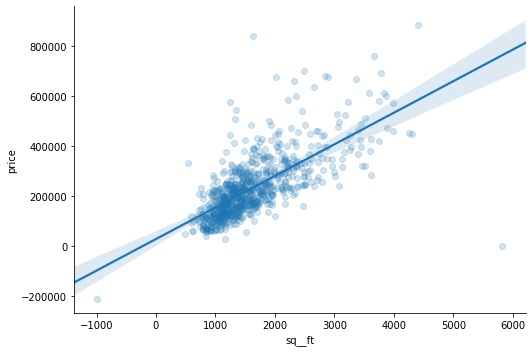

In [30]:
# Square Feet v Price
sns.lmplot(x='sq__ft', y='price', data=df_sqft_not_0, aspect=1.5,scatter_kws={'alpha':0.2});

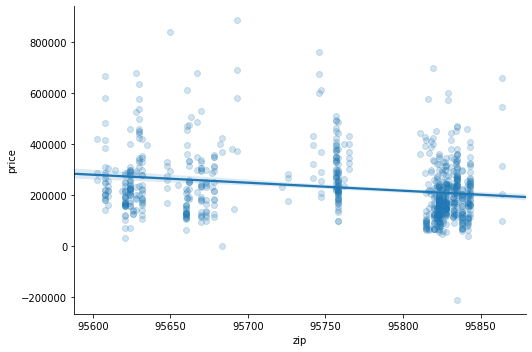

In [31]:
# Square Feet v Price
# Plot is not useful as Zip is not a continuous variable
sns.lmplot(x='zip', y='price', data=df_sqft_not_0, aspect=1.5,scatter_kws={'alpha':0.2});

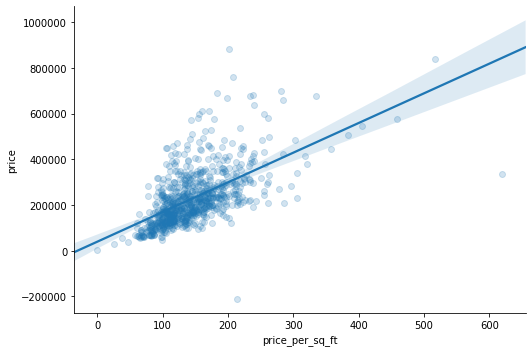

In [32]:
# Square Feet v Price
# This variable is included for fun
sns.lmplot(x='price_per_sq_ft', y='price', data=df_sqft_not_0, aspect=1.5,scatter_kws={'alpha':0.2});

In [33]:
# Residential and Zip cannot be plotted against as price is they are both categorical feature

### 4. Which variable would be the best predictor of Y in a SLR model? Why?

In [34]:
# sq_ft. It has a 0.699 correlation to price
df_sqft_not_0.corr()

,zip,beds,baths,sq__ft,price,latitude,longitude,price_per_sq_ft
zip,1.000000,-0.072673,-0.103332,-0.103798,-0.221494,-0.033255,0.018229,-0.184373
beds,-0.072673,1.000000,0.654746,0.699234,0.449685,0.090044,-0.091274,-0.126587
baths,-0.103332,0.654746,1.000000,0.723569,0.503875,0.048521,-0.048055,-0.059380
sq__ft,-0.103798,0.699234,0.723569,1.000000,0.699157,0.132511,-0.131952,-0.068303
price,-0.221494,0.449685,0.503875,0.699157,1.000000,0.129047,-0.121856,0.589889
latitude,-0.033255,0.090044,0.048521,0.132511,0.129047,1.000000,-0.999354,-0.040211
longitude,0.018229,-0.091274,-0.048055,-0.131952,-0.121856,-0.999354,1.000000,0.048831
price_per_sq_ft,-0.184373,-0.126587,-0.059380,-0.068303,0.589889,-0.040211,0.048831,1.000000


In [35]:
# Square feet as it is strongly correlated with price

### 5. Build a function that will take in two lists `Y` and `X` and returns the intercept and slope coefficients that minimize SSE. 

`Y` is the target variable and `X` is the predictor variable.

- **Test your function on price and the variable you determined was the best predictor in Problem 4.**
- **Report the slope and intercept.**

In [36]:
df_sqft_not_0.shape

(814, 14)

In [37]:
# Create X and y.
feature_cols = ['sq__ft']
X = df_sqft_not_0[feature_cols]
y = df_sqft_not_0.price
print(X)
print(y)

     sq__ft
0       836
1      1167
2       796
3       852
4       797
..      ...
980    2280
981    1477
982    1216
983    1685
984    1362

[814 rows x 1 columns]
0       59222
1       68212
2       68880
3       69307
4       81900
        ...  
980    232425
981    234000
982    235000
983    235301
984    235738
Name: price, Length: 814, dtype: int64


In [38]:
# Check X's type.
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [39]:
# Check y's type.
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [42]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
#lr.predict(np.array([0]).reshape(-1,1))
#lr.predict(np.array([0]))
X_test = [[0]]
lr.predict(X_test)

array([28521.05799033])

In [44]:
print(lr.intercept_)
print(lr.coef_)

28521.05799033254
[126.14428564]


### 6. Interpret the intercept. Interpret the slope.

In [45]:
# If sq foot = 0, the house is still worth 28521 which is nonsense
# Each additional sq ft adds $126 to the price

### 7. Give an example of how this model could be used for prediction and how this model could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

In [46]:
# prediciton could calculate fair price for a buyer or seller who is looking to know if they are buying or selling at a fair market price. 

### 8: [Bonus] Using the model you came up with in Problem 5, calculate and plot the residuals.

In [47]:
# create an array of predicted values for all values of X 
y_predict = lr.predict(X)
y_predict

array([133977.68078478, 175731.43933138, 128931.90935921, 135995.98935501,
       129058.05364485, 170054.94647761, 167784.34933611, 176992.88218778,
       147222.8307769 , 173082.40933296, 143186.21363645, 191121.04217938,
       138392.73078215, 157188.22934241, 157440.51791369, 171568.67790529,
       134986.83506989, 128805.76507357, 102693.89794623, 199572.70931721,
       169550.36933506, 196166.81360495, 184939.97218305, 230478.05929883,
       142177.05935133, 165766.04076588, 149998.00506097, 169676.5136207 ,
       202600.17217255, 185949.12646817, 159584.97076955, 173839.27504679,
       202600.17217255, 169298.08076378, 159584.97076955, 207393.65502684,
       165009.17505204, 214205.44645137, 173082.40933296, 124390.71507619,
       193013.20646397, 180777.21075695, 161729.42362542, 160089.54791211,
       228712.03929988, 169802.65790634, 227829.02930041, 275133.13641514,
       237415.99500899, 214836.16787956, 178380.46932981, 229090.4721568 ,
       213070.14788061, 2

In [48]:
# Turn y_predict from an array into a series
y_predict_series = pd.Series(y_predict)
y_predict_series

0      133977.680785
1      175731.439331
2      128931.909359
3      135995.989355
4      129058.053645
           ...      
809    316130.029248
810    214836.167880
811    181912.509328
812    241074.179293
813    200329.575031
Length: 814, dtype: float64

In [49]:
# convert price from the dataframe into a series and call the series y_series
y_series = pd.Series(df_sqft_not_0.price.values)
y_series

0       59222
1       68212
2       68880
3       69307
4       81900
        ...  
809    232425
810    234000
811    235000
812    235301
813    235738
Length: 814, dtype: int64

In [50]:
# calculate the residuals and call the series y_minus_y_pred_series 
y_minus_y_pred_series = y_series.subtract(y_predict_series, fill_value=0)
y_minus_y_pred_series

0      -74755.680785
1     -107519.439331
2      -60051.909359
3      -66688.989355
4      -47158.053645
           ...      
809    -83705.029248
810     19163.832120
811     53087.490672
812     -5773.179293
813     35408.424969
Length: 814, dtype: float64

In [51]:
# extract sq_ft as a series and call it X
X_series = pd.Series(df_sqft_not_0.sq__ft.values)
X_series

0       836
1      1167
2       796
3       852
4       797
       ... 
809    2280
810    1477
811    1216
812    1685
813    1362
Length: 814, dtype: int64

In [52]:
# Convert X_series into a new dataframe
df_X_series = pd.DataFrame(X_series)
df_X_series

,0
0,836
1,1167
2,796
3,852
4,797
...,...
809,2280
810,1477
811,1216
812,1685


In [53]:
y_minus_y_pred_series

0      -74755.680785
1     -107519.439331
2      -60051.909359
3      -66688.989355
4      -47158.053645
           ...      
809    -83705.029248
810     19163.832120
811     53087.490672
812     -5773.179293
813     35408.424969
Length: 814, dtype: float64

In [54]:
# Convert X_series into a new dataframe
df_residuals = pd.DataFrame(y_minus_y_pred_series)
df_residuals

,0
0,-74755.680785
1,-107519.439331
2,-60051.909359
3,-66688.989355
4,-47158.053645
...,...
809,-83705.029248
810,19163.832120
811,53087.490672
812,-5773.179293


In [55]:
df_X_against_residuals = pd.concat([df_X_series, df_residuals], axis = 1)
df_X_against_residuals

,0,0
0,836,-74755.680785
1,1167,-107519.439331
2,796,-60051.909359
3,852,-66688.989355
4,797,-47158.053645
...,...,...
809,2280,-83705.029248
810,1477,19163.832120
811,1216,53087.490672
812,1685,-5773.179293


In [56]:
df_X_against_residuals.columns = ['X', 'residuals']
df_X_against_residuals

,X,residuals
0,836,-74755.680785
1,1167,-107519.439331
2,796,-60051.909359
3,852,-66688.989355
4,797,-47158.053645
...,...,...
809,2280,-83705.029248
810,1477,19163.832120
811,1216,53087.490672
812,1685,-5773.179293


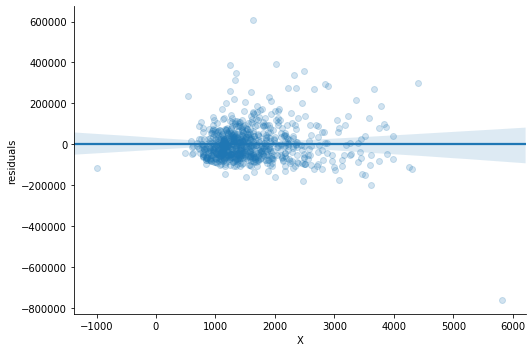

In [57]:
# plot the residuals against X 
sns.lmplot(x='X', y='residuals', data=df_X_against_residuals, aspect=1.5, scatter_kws={'alpha':0.2});

### 9: Additional analysis using one hot encoding 

In [58]:
df_sqft_not_0.head(1)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,zero_sq__ft,price_per_sq_ft
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,>0_sq_ft,70.839713


In [59]:
# create dummy variables for residential using 'get dummies' from Pandas
type_dummies = pd.get_dummies(df_sqft_not_0.type, prefix='type')

In [60]:
# Print five random rows.
type_dummies.sample(n=5, random_state=1)

,type_Condo,type_Multi-Family,type_Residential
397,0,0,1
800,0,0,1
652,0,0,1
976,0,0,1
8,1,0,0


In [61]:
type_dummies.drop(type_dummies.columns[2], axis=1, inplace=True)

In [62]:
# Print five random rows.
type_dummies.sample(n=5, random_state=1)

,type_Condo,type_Multi-Family
397,0,0
800,0,0
652,0,0
976,0,0
8,1,0


In [63]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
df_sqft_not_0_dummies = pd.concat([df_sqft_not_0, type_dummies], axis=1)

# Print 5 random rows.
df_sqft_not_0_dummies.sample(n=5, random_state=1)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,zero_sq__ft,price_per_sq_ft,type_Condo,type_Multi-Family
397,8363 LANGTREE WAY,SACRAMENTO,95823,CA,3,2,1452,Residential,Mon May 19 00:00:00 EDT 2008,160000,38.453560,-121.435959,>0_sq_ft,110.192837,0,0
800,1214 DAWNWOOD DR,GALT,95632,CA,3,2,1548,Residential,Fri May 16 00:00:00 EDT 2008,328370,38.290119,-121.286023,>0_sq_ft,212.125323,0,0
652,925 COBDEN CT,GALT,95632,CA,3,2,1140,Residential,Fri May 16 00:00:00 EDT 2008,162000,38.282047,-121.295812,>0_sq_ft,142.105263,0,0
976,2400 INVERNESS DR,LINCOLN,95648,CA,3,2,1358,Residential,Thu May 15 00:00:00 EDT 2008,229027,38.897814,-121.324691,>0_sq_ft,168.650221,0,0
8,11150 TRINITY RIVER DR Unit 114,RANCHO CORDOVA,95670,CA,2,2,941,Condo,Wed May 21 00:00:00 EDT 2008,94905,38.621188,-121.270555,>0_sq_ft,100.855473,1,0


In [64]:
# Include dummy variables for season in the model.
feature_cols = ['sq__ft', 'type_Multi-Family', 'type_Condo']
X =df_sqft_not_0_dummies[feature_cols]
y = df_sqft_not_0_dummies.price

linreg = LinearRegression()
linreg.fit(X, y)

print(list(zip(feature_cols, linreg.coef_)))
print('type has a significant impact on price')

[('sq__ft', 125.32695365296301), ('type_Multi-Family', -64112.90815184457), ('type_Condo', -24603.61574926061)]
type has a significant impact on price


In [65]:
# Check mean sq ft by type
df_sqft_not_0_dummies.groupby('type').sq__ft.mean()

type
Condo            930.833333
Multi-Family    2046.923077
Residential     1617.285903
Name: sq__ft, dtype: float64

In [66]:
# Analysis shows that type has a significant impact on price
# Although multifamily have over 20% more square footage than residential,its price is on average 64112 lower. 

In [67]:
# Check mean price
df_sqft_not_0_dummies.price.mean()

228930.07985257986

In [68]:
# List unique zips
df_sqft_not_0_dummies.zip.unique()

array([95838, 95823, 95815, 95824, 95841, 95842, 95820, 95670, 95673,
       95822, 95621, 95833, 95660, 95834, 95843, 95832, 95827, 95828,
       95758, 95626, 95825, 95835, 95624, 95632, 95826, 95608, 95662,
       95630, 95829, 95655, 95757, 95726, 95818, 95742, 95683, 95693,
       95831, 95814, 95635, 95864, 95817, 95628, 95667, 95610, 95722,
       95816, 95678, 95747, 95648, 95819, 95811, 95682, 95765, 95661,
       95650, 95821, 95603, 95762, 95677, 95623, 95663, 95746, 95619,
       95614, 95690, 95691])

In [69]:
# Count unique zips 
df_sqft_not_0_dummies.zip.nunique()

66

In [70]:
# check mean price by zip
df_sqft_not_0_dummies.groupby('zip').price.mean()

zip
95603    321818.000000
95608    295684.750000
95610    226436.285714
95614    300000.000000
95619    216033.000000
             ...      
95838    144036.527778
95841    213806.142857
95842    143281.772727
95843    232496.393939
95864    364400.000000
Name: price, Length: 66, dtype: float64

In [71]:
# A next step could do one hot encoding on zip but am passing on this for now!!!